In [1]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 08:18:26.958959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744705107.158199      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744705107.217952      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

--2025-04-15 08:18:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-15 08:18:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-15 08:18:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    if not valid_votes:
        return None
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0

In [4]:
hs_df = pd.read_csv('/kaggle/input/hate-speech-english/english_dataset.tsv', sep='\t')
hs_df = hs_df.drop(columns=['text_id', 'task_2', 'task_3'])
hs_df = hs_df.rename(columns={'task_1': 'label'})
hs_df['label'] = hs_df['label'].map({'NOT': 0, 'HOF': 1})
hs_df['text'] = hs_df['text'].apply(normalize_text)

hurtlex_df = pd.read_csv('/kaggle/input/hurtlex/hurtlex_EN.tsv', sep='\t', engine='python', on_bad_lines='skip')
hurtlex_dict = {}
for _, row in hurtlex_df.iterrows():
    word = str(row['lemma']).strip().lower()
    cat = str(row['category']).strip()
    if word not in hurtlex_dict:
        hurtlex_dict[word] = set()
    hurtlex_dict[word].add(cat)

all_categories = sorted({c for cats in hurtlex_dict.values() for c in cats})
cat2idx = {c: i for i, c in enumerate(all_categories)}
num_cats = len(cat2idx)

# HurtLex vectorizer
def get_hurtlex_vector(text):
    vec = np.zeros(num_cats)
    for token in text.split():
        if token in hurtlex_dict:
            for cat in hurtlex_dict[token]:
                vec[cat2idx[cat]] = 1
    return vec

# Generate features
hurtlex_features = np.array([get_hurtlex_vector(text) for text in hs_df['text']])

In [5]:
# GloVe-based tokenizer
max_features = 4479
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(hs_df['text'])


X_hs = pad_sequences(keras_tokenizer.texts_to_sequences(hs_df['text']), maxlen=max_len, padding='post')
y_hs = hs_df['label'].tolist()
X_hs_train, X_hs_val, y_hs_train, y_hs_val = train_test_split(X_hs, y_hs, test_size=0.3, random_state=42, shuffle=True)
text_train, text_val = train_test_split(hs_df['text'].tolist(), test_size=0.3, random_state=42, shuffle=True)

# Load GloVe embeddings
embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_features, embed_size))
for word, i in keras_tokenizer.word_index.items():
    if i < max_features and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

In [6]:
class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, labels, tokenizer, hurtlex_inputs=None, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.hurtlex_inputs = hurtlex_inputs
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': bert_encoded['input_ids'].squeeze(),
            'attention_mask': bert_encoded['attention_mask'].squeeze(),
            'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        if self.hurtlex_inputs is not None:
            item['hurtlex_input'] = torch.tensor(self.hurtlex_inputs[idx], dtype=torch.float)
        return item

In [7]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [8]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix, hurtlex_input_dim):
        super(FusionClassifier, self).__init__()

        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        self.hurtlex_fc = nn.Sequential(
            nn.Linear(hurtlex_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128)  # Output size matches x1, x2
        )

        # New output dimension: 512 (x1, x2, x1-x2, x1*x2) + 128 (x3)
        self.fusion_head = nn.Sequential(
            nn.Linear(640, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(glove_input)               # (B, 128)
        x3 = self.hurtlex_fc(hurtlex_input)                 # (B, 128)
        x = torch.cat([x1, x2, x1 - x2, x1 * x2, x3], dim=1)  # (B, 640)
        return self.fusion_head(x)

In [9]:
from transformers import AutoTokenizer
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_hurtlex = np.array([get_hurtlex_vector(t) for t in text_train])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in text_val])

train_dataset = FusionDataset(text_train, X_hs_train, y_hs_train, tokenizer,train_hurtlex)
val_dataset = FusionDataset(text_val, X_hs_val, y_hs_val, tokenizer,val_hurtlex)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

best_f1 = 0.0

for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            labels = batch["label"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            targets += labels.cpu().tolist()

    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    f1 = f1_score(targets, preds, average="weighted")
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_hurtlex_english_pretrained_hate.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f"Saved best model (F1: {best_f1:.4f})")


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]


Epoch 1/10


Training:   0%|          | 0/256 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Training: 100%|██████████| 256/256 [00:49<00:00,  5.14it/s]


Train Loss: 0.7052 | Val Loss: 0.6423 | F1: 0.6075 | Precision: 0.6372 | Recall: 0.6498
Saved best model (F1: 0.6075)

Epoch 2/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.30it/s]


Train Loss: 0.6828 | Val Loss: 0.6421 | F1: 0.6020 | Precision: 0.6294 | Recall: 0.6446

Epoch 3/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6578 | Val Loss: 0.6266 | F1: 0.5866 | Precision: 0.6531 | Recall: 0.6509

Epoch 4/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6519 | Val Loss: 0.6113 | F1: 0.6563 | Precision: 0.6744 | Recall: 0.6811
Saved best model (F1: 0.6563)

Epoch 5/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.28it/s]


Train Loss: 0.6371 | Val Loss: 0.5981 | F1: 0.6458 | Precision: 0.6888 | Recall: 0.6839

Epoch 6/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.28it/s]


Train Loss: 0.6254 | Val Loss: 0.5992 | F1: 0.6643 | Precision: 0.6797 | Recall: 0.6862
Saved best model (F1: 0.6643)

Epoch 7/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6177 | Val Loss: 0.5974 | F1: 0.6552 | Precision: 0.6794 | Recall: 0.6834

Epoch 8/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6200 | Val Loss: 0.6239 | F1: 0.6617 | Precision: 0.6611 | Recall: 0.6623

Epoch 9/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6000 | Val Loss: 0.5992 | F1: 0.6670 | Precision: 0.6753 | Recall: 0.6839
Saved best model (F1: 0.6670)

Epoch 10/10


Training: 100%|██████████| 256/256 [00:48<00:00,  5.27it/s]


Train Loss: 0.6008 | Val Loss: 0.6097 | F1: 0.6718 | Precision: 0.6713 | Recall: 0.6794
Saved best model (F1: 0.6718)


In [10]:
df = pd.read_csv("/kaggle/input/gender-abuse-dataset/train_en_l1.csv")
annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']

df['label'] = df[annotation_cols].apply(get_majority_label, axis=1)
df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(int)
df['text'] = df['text'].apply(normalize_text)

# Reuse tokenizer from hate speech
X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_glove = pad_sequences(X_seq, maxlen=100, padding='post')
y = df['label'].tolist()

train_texts, val_texts, train_glove, val_glove, train_y, val_y = train_test_split(
    df['text'].tolist(), X_glove, y, test_size=0.2, random_state=42
)

/tmp/ipykernel_31/4029243057.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_english_pretrained_hate.pt"))
Epoch 1: 100

Epoch 1 | F1: 0.7676 | Precision: 0.7671 | Recall: 0.7682
Saved best model (F1: 0.7676)


Epoch 2: 100%|██████████| 327/327 [01:02<00:00,  5.23it/s]


Epoch 2 | F1: 0.7232 | Precision: 0.7810 | Recall: 0.6955


Epoch 3: 100%|██████████| 327/327 [01:02<00:00,  5.22it/s]


Epoch 3 | F1: 0.7425 | Precision: 0.7799 | Recall: 0.7215


Epoch 4: 100%|██████████| 327/327 [01:02<00:00,  5.23it/s]


Epoch 4 | F1: 0.7182 | Precision: 0.7840 | Recall: 0.6886


Epoch 5: 100%|██████████| 327/327 [01:02<00:00,  5.25it/s]


Epoch 5 | F1: 0.7618 | Precision: 0.7836 | Recall: 0.7475


Epoch 6: 100%|██████████| 327/327 [01:02<00:00,  5.23it/s]


Epoch 6 | F1: 0.7430 | Precision: 0.7845 | Recall: 0.7207


Epoch 7: 100%|██████████| 327/327 [01:02<00:00,  5.23it/s]
/tmp/ipykernel_31/4029243057.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load

Epoch 7 | F1: 0.7355 | Precision: 0.7844 | Recall: 0.7108



Final Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.89      0.74      0.80      1056
        Hate       0.35      0.61      0.45       251

    accuracy                           0.71      1307
   macro avg       0.62      0.67      0.63      1307
weighted avg       0.78      0.71      0.74      1307



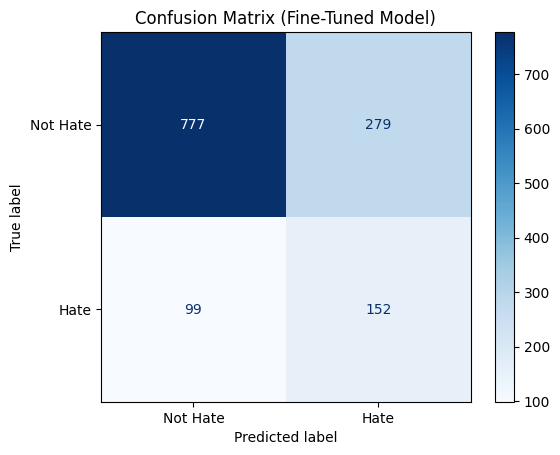

In [11]:
train_hurtlex = np.array([get_hurtlex_vector(t) for t in train_texts])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in val_texts])
train_dataset = FusionDataset(train_texts, train_glove, train_y, tokenizer, train_hurtlex)
val_dataset = FusionDataset(val_texts, val_glove, val_y, tokenizer, val_hurtlex)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

label_counts = Counter(train_y)
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = [w / sum(class_weights) for w in class_weights]
class_weights_tensor = torch.tensor(class_weights).to(device)

model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_hurtlex_english_pretrained_hate.pt"))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
# criterion = nn.CrossEntropyLoss()
train_losses, val_losses = [], []

for epoch in range(7):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        loss = criterion(model(**inputs), batch["label"].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_preds, val_targets = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
            out = model(**inputs)
            val_loss += criterion(out, batch["label"].to(device)).item()
            val_preds += torch.argmax(out, dim=1).cpu().tolist()
            val_targets += batch["label"].tolist()

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(val_targets, val_preds, average='weighted')
    precision = precision_score(val_targets, val_preds, average='weighted')
    recall = recall_score(val_targets, val_preds, average='weighted')
    print(f"Epoch {epoch+1} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "fusion_hurtlex_english_finetuned_on_abuse.pt")
        print(f"Saved best model (F1: {best_f1:.4f})")

model.load_state_dict(torch.load("fusion_hurtlex_english_finetuned_on_abuse.pt"))
model.eval()

final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        final_preds += torch.argmax(outputs, dim=1).cpu().tolist()
        final_targets += labels.cpu().tolist()
print("\nFinal Classification Report:\n")
print(classification_report(val_targets, val_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Fine-Tuned Model)")
plt.show()

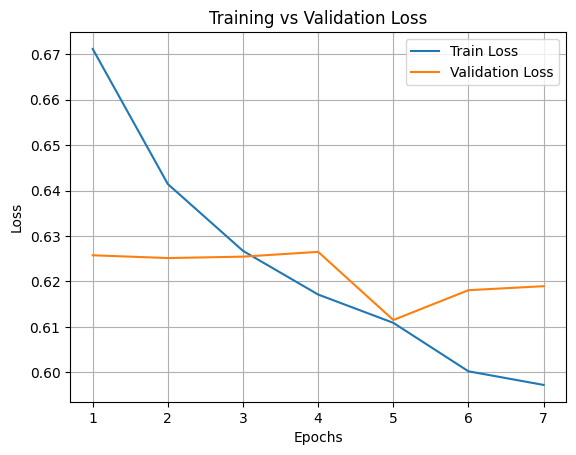

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/958845886.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_hurtlex_english_finetuned_on_abuse.pt"))


Saved predictions to: Task2_output_English.csv

F1-score: 0.7238 | Precision: 0.7171 | Recall: 0.7317

Classification Report:

              precision    recall  f1-score   support

    Not Hate       0.82      0.85      0.83       877
        Hate       0.33      0.28      0.30       230

    accuracy                           0.73      1107
   macro avg       0.57      0.57      0.57      1107
weighted avg       0.72      0.73      0.72      1107



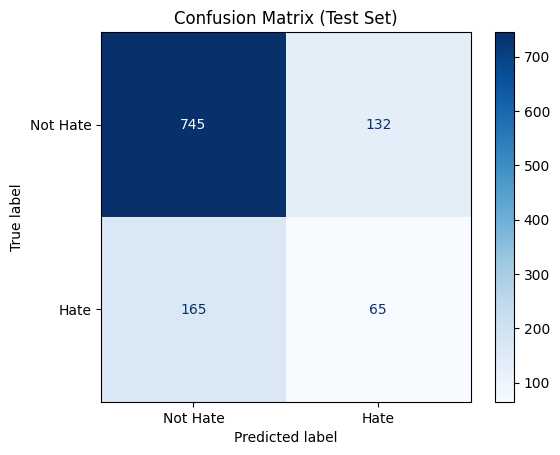

In [14]:
test_df = pd.read_csv("/kaggle/input/gender-abuse-dataset/test_en_l1.csv")
annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']

test_df['label'] = test_df[annotation_cols].apply(get_majority_label, axis=1)
test_df = test_df[['text', 'label']].dropna()
test_df['label'] = test_df['label'].astype(int)
test_df['text'] = test_df['text'].apply(normalize_text)

# Tokenize and encode
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_labels = test_df['label'].tolist()
test_hurtlex = np.array([get_hurtlex_vector(text) for text in test_df['text']])
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_labels, tokenizer, hurtlex_inputs=test_hurtlex)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_hurtlex_english_finetuned_on_abuse.pt"))
model.eval()

# Run inference
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(labels.cpu().tolist())

output_df = pd.DataFrame({'id': np.arange(1, len(all_preds)+1), 'value': all_preds})
output_df.to_csv('/kaggle/working/Task2_output_English.csv', index=False)
print("Saved predictions to: Task2_output_English.csv")

f1 = f1_score(all_targets, all_preds, average="weighted")
precision = precision_score(all_targets, all_preds, average="weighted")
recall = recall_score(all_targets, all_preds, average="weighted")
print(f"\nF1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=["Not Hate", "Hate"]))

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()